In [1]:
from dolfinx import mesh, fem, plot, geometry
import dolfinx.fem.petsc
import dolfinx.nls.petsc
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from ufl import dx, grad, dot, jump, avg
import numpy as np
import matplotlib.pyplot as plt
import pyvista


msh = mesh.create_unit_square(MPI.COMM_WORLD, 100, 100)
V = fem.FunctionSpace(msh, ("DG", 1))
uD = fem.Function(V)
uD.interpolate(lambda x: np.full(x[0].shape, 0.0))

# create mesh tags
def marker_interface(x):
    return np.isclose(x[0], 0.5)

tdim = msh.topology.dim
fdim = tdim - 1
msh.topology.create_connectivity(fdim, tdim)
facet_imap = msh.topology.index_map(tdim - 1)
boundary_facets = mesh.exterior_facet_indices(msh.topology)
interface_facets = mesh.locate_entities(msh, tdim - 1, marker_interface)
num_facets = facet_imap.size_local + facet_imap.num_ghosts
indices = np.arange(0, num_facets)
# values = np.arange(0, num_facets, dtype=np.intc)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

values[boundary_facets] = 1
values[interface_facets] = 2

mesh_tags_facets = mesh.meshtags(msh, tdim - 1, indices, values) 

ds = ufl.Measure("ds", domain=msh, subdomain_data=mesh_tags_facets)
dS = ufl.Measure("dS", domain=msh, subdomain_data=mesh_tags_facets)
u = fem.Function(V)
u_n = fem.Function(V)
v = ufl.TestFunction(V)

h = ufl.CellDiameter(msh)
n = ufl.FacetNormal(msh)

# Define parameters
alpha = 1000

# Simulation constants
f = fem.Constant(msh, PETSc.ScalarType(2.0))
K1 = fem.Constant(msh, PETSc.ScalarType(2.0))
K2 = fem.Constant(msh, PETSc.ScalarType(4.0))

# Define variational problem
F = 0
F += dot(grad(v), grad(u))*dx - dot(v*n, grad(u))*ds \
   - dot(avg(grad(v)), jump(u, n))*dS(0) - dot(jump(v, n), avg(grad(u)))*dS(0) \
   + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(0) + alpha/h*v*u*ds

# source
F += -v*f*dx 

# Dirichlet BC
F += - dot(grad(v), u*n)*ds \
   + uD*dot(grad(v), n)*ds - alpha/h*uD*v*ds

# Interface BC
F += - dot(avg(grad(v)), n('-'))*(u('-')*(K1/K2-1))*dS(2)
F += alpha/avg(h)*dot(jump(v,n),n('-'))*(u('-')*(K1/K2-1))*dS(2)

# symmetry
F += - dot(avg(grad(v)), jump(u, n))*dS(2) 
# coercivity
F += + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(2)

problem = dolfinx.fem.petsc.NonlinearProblem(F, u)
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

(1, True)

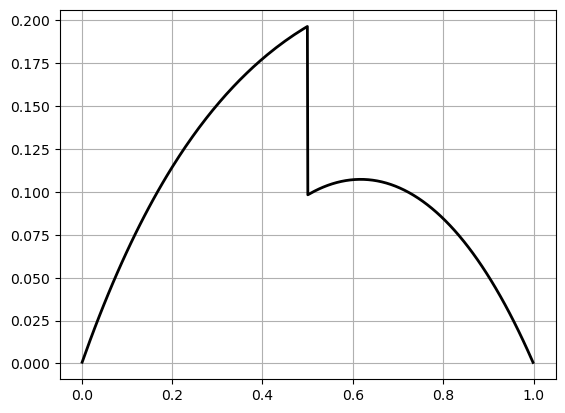

In [2]:
bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(0 + tol, 1 - tol, n_points)
y = np.ones(n_points)*0.5
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
plt.grid(True)
# plt.savefig('lineplot_u_over_k.jpg')


In [3]:
u_jump = u_values[int(n_points/2)] - u_values[int(n_points/2)-1]
u_ratio = u_values[int(n_points/2)] / u_values[int(n_points/2)-1]
print(f'Jump on the interface {u_ratio}')

Jump on the interface [0.50058936]


In [4]:

pyvista.OFF_SCREEN = False

pyvista.start_xvfb()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = u.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("DG.png")

OSError: Please install Xvfb with:

Debian
$ sudo apt install libgl1-mesa-glx xvfb

CentOS / RHL
$ sudo yum install libgl1-mesa-glx xvfb



In [ ]:
u_comsol = np.loadtxt('results_PC_comsol.csv', delimiter=',')[::10][:,1]

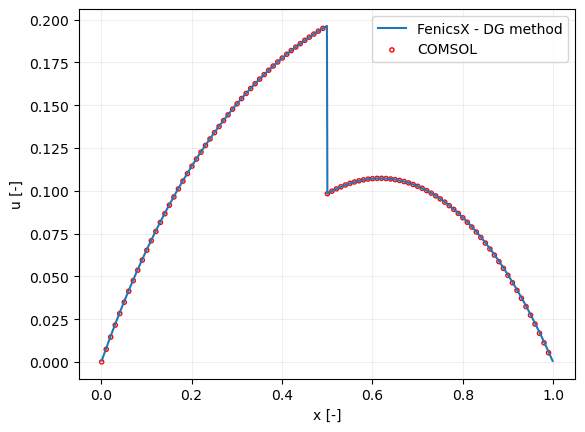

In [ ]:
plt.plot(x, u_values, label = 'FenicsX - DG method')
plt.scatter(x[::10], u_comsol, marker = '.', facecolors='none', edgecolors='r', label = 'COMSOL')
plt.legend()
plt.xlabel('x [-]')
plt.ylabel('u [-]')
plt.grid('on', alpha = 0.2)
plt.savefig('Verification_COMSOL.png', dpi = 300)

In [ ]:
# Check impact of alpha
import time 

alphas = np.logspace(-2,4,7)
run_time = []
res = []
for alpha in alphas:
    # reset time
    start_time = time.time()
    
    # Simulation constants
    f = fem.Constant(msh, PETSc.ScalarType(2.0))
    K1 = fem.Constant(msh, PETSc.ScalarType(2.0))
    K2 = fem.Constant(msh, PETSc.ScalarType(4.0))

    # Define variational problem
    F = 0
    F += dot(grad(v), grad(u))*dx - dot(v*n, grad(u))*ds \
    - dot(avg(grad(v)), jump(u, n))*dS(0) - dot(jump(v, n), avg(grad(u)))*dS(0) \
    + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(0) + alpha/h*v*u*ds

    # source
    F += -v*f*dx 

    # Dirichlet BC
    F += - dot(grad(v), u*n)*ds \
    + uD*dot(grad(v), n)*ds - alpha/h*uD*v*ds

    # Interface BC
    F += - dot(avg(grad(v)), n('-'))*(u('-')*(K1/K2-1))*dS(2)
    F += alpha/avg(h)*dot(jump(v,n),n('-'))*(u('-')*(K1/K2-1))*dS(2)

    # symmetry
    F += - dot(avg(grad(v)), jump(u, n))*dS(2)
    # coercivity
    F += + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(2)

    problem = dolfinx.fem.petsc.NonlinearProblem(F, u)
    solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
    solver.solve(u)
    run_time.append(time.time() - start_time)
    bb_tree = geometry.bb_tree(msh, msh.topology.dim)
    n_points = 1000
    tol = 0.001  # Avoid hitting the outside of the domain
    x = np.linspace(0 + tol, 1 - tol, n_points)
    y = np.ones(n_points)*0.5
    points = np.zeros((3, n_points))
    points[0] = x
    points[1] = y
    u_values = []
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    u_values = u.eval(points_on_proc, cells)
    u_jump = u_values[int(n_points/2)] - u_values[int(n_points/2)-1]
    u_ratio = u_values[int(n_points/2)]/ u_values[int(n_points/2)-1]
    res.append(u_ratio)


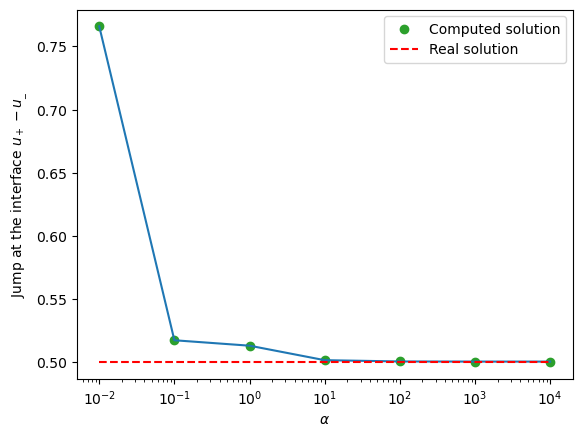

In [ ]:
# Plot convergence 
plt.scatter(alphas,res, label = 'Computed solution', c='tab:green')
plt.plot(alphas, res)
plt.hlines(0.5, xmin=alphas[0], xmax=alphas[-1], colors='r', linestyles='--', label= 'Real solution')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Jump at the interface $u_+ - u_\_$')
plt.xscale('log')


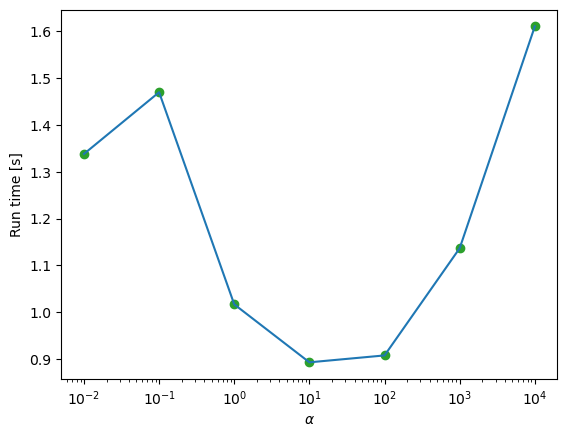

In [ ]:
plt.scatter(alphas,run_time, label = 'Computed solution', c='tab:green')
plt.plot(alphas,run_time)
plt.xlabel(r'$\alpha$')
plt.ylabel('Run time [s]')
plt.xscale('log')

In [ ]:
alpha = 1e8
# Define variational problem
F = 0
F += dot(grad(v), grad(u))*dx - dot(v*n, grad(u))*ds \
- dot(avg(grad(v)), jump(u, n))*dS(0) - dot(jump(v, n), avg(grad(u)))*dS(0) \
+ alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(0) + alpha/h*v*u*ds

# source
F += -v*f*dx 

# Dirichlet BC
F += - dot(grad(v), u*n)*ds \
+ uD*dot(grad(v), n)*ds - alpha/h*uD*v*ds

# Interface BC
F += - dot(avg(grad(v)), n('-'))*(u('-')*(K1/K2-1))*dS(2)
F += alpha/avg(h)*dot(jump(v,n),n('-'))*(u('-')*(K1/K2-1))*dS(2)

# symmetry
F += - dot(avg(grad(v)), jump(u, n))*dS(2)
# coercivity
F += + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(2)

problem = dolfinx.fem.petsc.NonlinearProblem(F, u)
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

RuntimeError: Newton solver did not converge because maximum number of iterations reached